# INSTALL LIBRARY OPENDATASETS

In [1]:
! pip install opendatasets

In [2]:
"""

{"username":"sudoss",

"key":"41226d8167793de7435b5d64a19b216e"}

"""

' \n\n{"username":"sudoss",\n\n"key":"41226d8167793de7435b5d64a19b216e"}\n\n'

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sudoss
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:37<00:00, 66.5MB/s]


# STEP - 1 IMPORT ALL LIBRARIES REQUIRED FOR THE MODEL

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from tensorflow.keras.preprocessing import image
import cv2

# STEP - 2 Display a Tree Structure of All Image Files in a Directory

In [5]:
import os

base_dir = './chest-xray-pneumonia'

# List directories and files in the base directory
for root, dirs, files in os.walk(base_dir):
    level = root.replace(base_dir, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        if f.endswith('.jpeg') or f.endswith('.png'):
            print(f'{subindent}{f}')

chest-xray-pneumonia/
    chest_xray/
        train/
            NORMAL/
                NORMAL2-IM-0857-0001.jpeg
                IM-0361-0001.jpeg
                NORMAL2-IM-0909-0001.jpeg
                IM-0191-0001.jpeg
                NORMAL2-IM-1293-0001.jpeg
                IM-0391-0001.jpeg
                IM-0326-0001.jpeg
                NORMAL2-IM-0775-0001.jpeg
                NORMAL2-IM-1244-0001.jpeg
                NORMAL2-IM-1190-0001.jpeg
                IM-0488-0001.jpeg
                IM-0276-0001.jpeg
                IM-0533-0001-0002.jpeg
                NORMAL2-IM-1016-0001.jpeg
                IM-0156-0001.jpeg
                NORMAL2-IM-1033-0001.jpeg
                NORMAL2-IM-0473-0001.jpeg
                IM-0580-0001.jpeg
                IM-0620-0001.jpeg
                NORMAL2-IM-1292-0001.jpeg
                IM-0705-0001.jpeg
                NORMAL2-IM-1189-0001.jpeg
                NORMAL2-IM-0999-0001.jpeg
                NORMAL2-IM-0966-0001.jpeg
  

# Step 3: Set the base directory for the already downloaded data
# The data is downloaded to './chest-xray-pneumonia' by opendatasets

In [6]:

base_dir = './chest-xray-pneumonia'

# Step 1: Generate CSV labels from folder structure
def generate_labels_csv(base_dir, output_csv='labels.csv'):
    data = []
    # The actual image directories are nested within 'chest_xray'
    dataset_dir = os.path.join(base_dir, 'chest_xray')
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(dataset_dir, split) # Corrected path
        if os.path.exists(split_dir):
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_dir = os.path.join(split_dir, class_name)
                if os.path.exists(class_dir):
                    for img_file in os.listdir(class_dir):
                        if img_file.endswith('.jpeg') or img_file.endswith('.png'):
                            data.append({
                                'filename': os.path.join('chest_xray', split, class_name, img_file), # Corrected filename path in dataframe
                                'label': class_name,  # Use string labels for class_mode='binary'
                                'split': split
                            })
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Generated {output_csv} with {len(df)} entries.")
    return df

# Step 4: Preprocessing function (optional, not used in generators)

In [7]:
# Load dataset path (update to your extracted folder)
labels_df = generate_labels_csv(base_dir)


IMG_SIZE = (224, 224)  # Standard size for CNNs
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize to [0,1]
    return img

# Prepare train/test DataFrames (using original train split, further split for validation)
train_original_df = labels_df[labels_df['split'] == 'train']
train_df, val_df = train_test_split(train_original_df, test_size=0.2, stratify=train_original_df['label'], random_state=42)
test_df = labels_df[labels_df['split'] == 'test']  # Use original test split

print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")


Generated labels.csv with 5856 entries.
Train samples: 4172, Val samples: 1044, Test samples: 624


# STEP - 5 PLOT IMAGES FOR PNEUMONIA And noraml x-rays

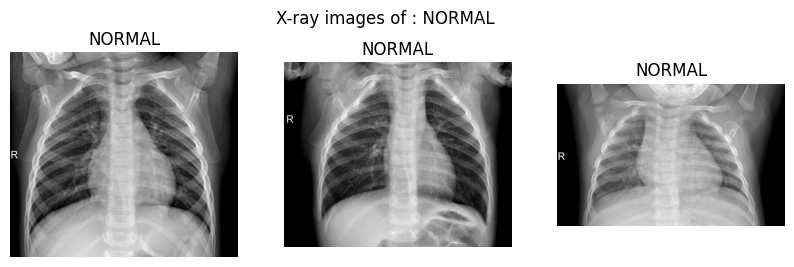

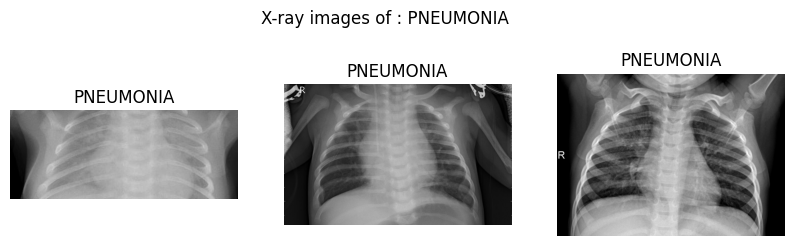

In [8]:

base_dir = './chest-xray-pneumonia'

sample_dir = os.path.join(base_dir, 'chest_xray', 'train')

for category in ['NORMAL', 'PNEUMONIA']:
    folder = os.path.join(sample_dir, category)
    sample_files = random.sample(os.listdir(folder), 3)
    plt.figure(figsize=(10, 3))
    for i, file in enumerate(sample_files):
        img_path = os.path.join(folder, file)
        img = mpimg.imread(img_path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(category)
        plt.axis('off')
    plt.suptitle(f"X-ray images of : {category}")
    plt.show()

# Step 6: Data Generators with Augmentation

In [9]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, base_dir, x_col='filename', y_col='label',
    target_size=IMG_SIZE, batch_size=32, class_mode='binary', shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, base_dir, x_col='filename', y_col='label',
    target_size=IMG_SIZE, batch_size=32, class_mode='binary', shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df, base_dir, x_col='filename', y_col='label',
    target_size=IMG_SIZE, batch_size=32, class_mode='binary', shuffle=False
)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# Step 7: Build CNN Model

> Add blockquote




In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

# Step 8: Train Model (using validation data)


In [11]:
train_generator.samples = 4172
train_generator.batch_size = 32
val_generator.samples = 1044
val_generator.batch_size = 32

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=1, # Reduced epochs for faster training
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 103s 735ms/step - accuracy: 0.7135 - loss: 0.9654 - val_accuracy: 0.7998 - val_loss: 0.3965


# Step 9: Evaluate on Test Set


In [13]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.8617 - loss: 0.4068
Test Accuracy: 0.79


# Predictions for report


In [14]:
test_generator.reset()  # Reset generator before prediction
y_pred_prob = model.predict(test_generator, steps=test_generator.samples) # Use total samples for steps
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step    
              precision    recall  f1-score   support

      Normal       0.66      0.91      0.77       234
   Pneumonia       0.93      0.73      0.81       390

    accuracy                           0.79       624
   macro avg       0.80      0.82      0.79       624
weighted avg       0.83      0.79      0.80       624



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


# Model Evaluation Metrics by Class

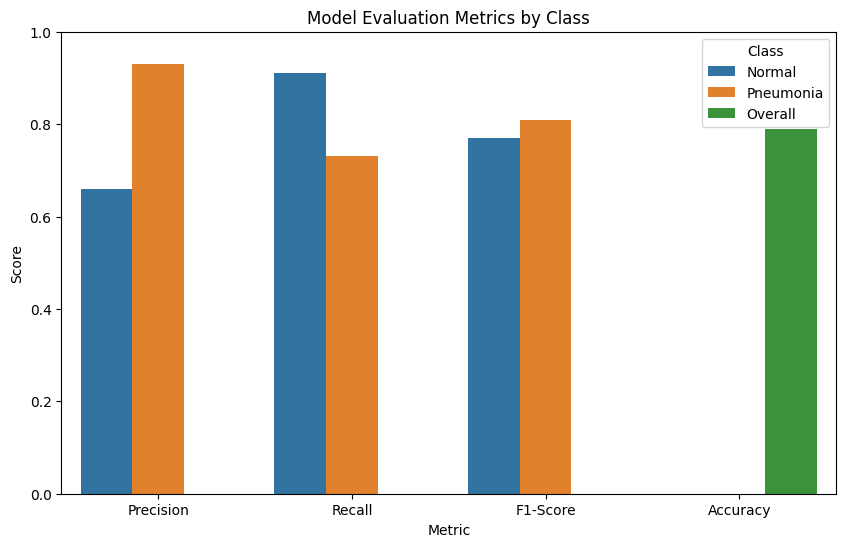

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # Import seaborn

# The classification_report output is a string, so we need to parse it.
report_lines = classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']).split('\n')

# Extract the lines with metrics for each class
normal_metrics_line = report_lines[2].split()
pneumonia_metrics_line = report_lines[3].split()
# The accuracy line is usually the 5th line (index 4) or 6th line (index 5)
# Let's robustly find the accuracy line by looking for 'accuracy'
accuracy_line = None
for line in report_lines:
    if 'accuracy' in line:
        accuracy_line = line.split()
        break

metrics_data = []

# Add precision, recall, f1-score for each class
metrics_data.append({'Metric': 'Precision', 'Class': 'Normal', 'Score': float(normal_metrics_line[1])})
metrics_data.append({'Metric': 'Recall', 'Class': 'Normal', 'Score': float(normal_metrics_line[2])})
metrics_data.append({'Metric': 'F1-Score', 'Class': 'Normal', 'Score': float(normal_metrics_line[3])})

metrics_data.append({'Metric': 'Precision', 'Class': 'Pneumonia', 'Score': float(pneumonia_metrics_line[1])})
metrics_data.append({'Metric': 'Recall', 'Class': 'Pneumonia', 'Score': float(pneumonia_metrics_line[2])})
metrics_data.append({'Metric': 'F1-Score', 'Class': 'Pneumonia', 'Score': float(pneumonia_metrics_line[3])})

# Add accuracy (overall) - it appears as a single value
if accuracy_line:
    metrics_data.append({'Metric': 'Accuracy', 'Class': 'Overall', 'Score': float(accuracy_line[1])})


metrics_df = pd.DataFrame(metrics_data)

# Plotting using seaborn barplot for easier handling of categories
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Class', data=metrics_df)
plt.title('Model Evaluation Metrics by Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Confusion Matrix Visualization


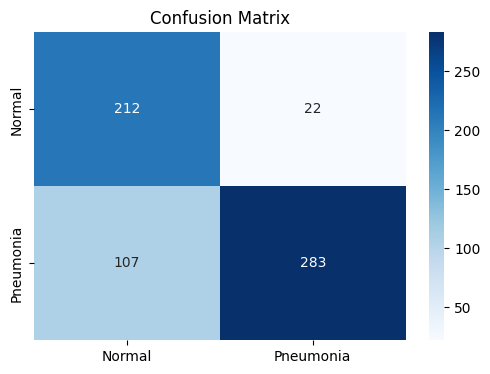

In [16]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.show()

# Plot Training History


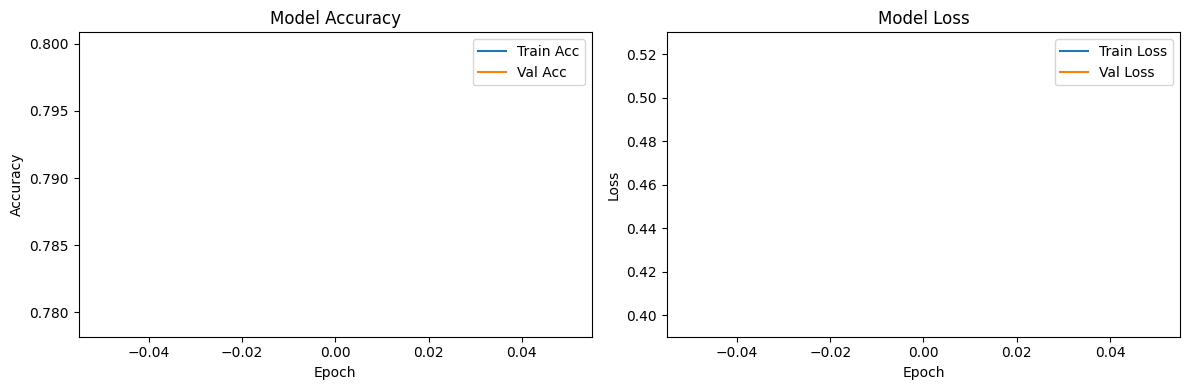

History keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Train Accuracy history: [0.779227077960968]
Validation Accuracy history: [0.7998046875]
Train Loss history: [0.5236160755157471]
Validation Loss history: [0.39654600620269775]


In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Print history content for debugging
print("History keys:", history.history.keys())
print("Train Accuracy history:", history.history.get('accuracy'))
print("Validation Accuracy history:", history.history.get('val_accuracy'))
print("Train Loss history:", history.history.get('loss'))
print("Validation Loss history:", history.history.get('val_loss'))

# PREDICTION OF PNEUMONIA AND NORMAL X-RAY

In [18]:
! pip install gTTS
from gtts import gTTS
from IPython.display import Audio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0


Saving pnemonia3.jpg to pnemonia3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
The model predicts: Pneumonia with 99.26% confidence.


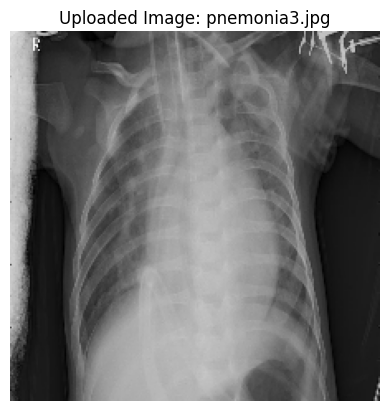

In [19]:
from google.colab import files
# Install gTTS if not already installed
try:
    from gtts import gTTS
    from IPython.display import Audio
except ImportError:
    ! pip install gTTS
    from gtts import gTTS
    from IPython.display import Audio

# Step 1: Upload the image
uploaded = files.upload()

# Add a check to ensure uploaded is a dictionary and has keys
if isinstance(uploaded, dict) and uploaded:
    for fn in uploaded.keys():
        # Step 2: Preprocess the image
        img_path = fn
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
        img = cv2.resize(img, IMG_SIZE) # Use the IMG_SIZE defined earlier
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Create a batch
        img_array /= 255.0 # Normalize the image

        # Step 3: Make a prediction
        prediction = model.predict(img_array)

        # Step 4: Interpret the result
        # Assuming class_mode='binary' in flow_from_dataframe and 0=Normal, 1=Pneumonia
        if prediction[0] > 0.5:
            result = 'Pneumonia'
            confidence = prediction[0][0] * 100
            speech_text = f"The model predicts: {result} with {confidence:.2f}% confidence. Potential treatment includes consulting a doctor for antibiotics or antiviral medication, getting plenty of rest, and staying hydrated."
        else:
            result = 'Normal'
            confidence = (1 - prediction[0][0]) * 100
            speech_text = f"The model predicts: {result} with {confidence:.2f}% confidence. Precautions for normal cases include maintaining good hygiene, avoiding close contact with sick people, and getting vaccinated against the flu and pneumococcal pneumonia."


        print(f"The model predicts: {result} with {confidence:.2f}% confidence.")

        # Step 5: Convert text to speech and play audio
        tts = gTTS(text=speech_text, lang='en')
        tts.save("prediction_audio.mp3")
        display(Audio("prediction_audio.mp3", autoplay=True))

        # Display the uploaded image
        plt.imshow(img)
        plt.title(f"Uploaded Image: {fn}")
        plt.axis('off')
        plt.show()
else:
    print("No file was uploaded or there was an issue with the upload.")

Saving normal.jpg to normal.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
The model predicts: Normal with 81.61% confidence.


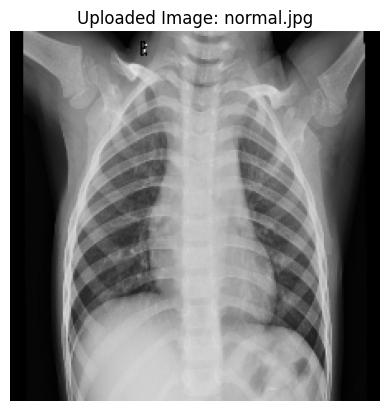

In [20]:
from google.colab import files
# Install gTTS if not already installed
try:
    from gtts import gTTS
    from IPython.display import Audio
except ImportError:
    ! pip install gTTS
    from gtts import gTTS
    from IPython.display import Audio

# Step 1: Upload the image
uploaded = files.upload()

# Add a check to ensure uploaded is a dictionary and has keys
if isinstance(uploaded, dict) and uploaded:
    for fn in uploaded.keys():
        # Step 2: Preprocess the image
        img_path = fn
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
        img = cv2.resize(img, IMG_SIZE) # Use the IMG_SIZE defined earlier
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Create a batch
        img_array /= 255.0 # Normalize the image

        # Step 3: Make a prediction
        prediction = model.predict(img_array)

        # Step 4: Interpret the result
        # Assuming class_mode='binary' in flow_from_dataframe and 0=Normal, 1=Pneumonia
        if prediction[0] > 0.5:
            result = 'Pneumonia'
            confidence = prediction[0][0] * 100
            speech_text = f"The model predicts: {result} with {confidence:.2f}% confidence. Potential treatment includes consulting a doctor for antibiotics or antiviral medication, getting plenty of rest, and staying hydrated."
        else:
            result = 'Normal'
            confidence = (1 - prediction[0][0]) * 100
            speech_text = f"The model predicts: {result} with {confidence:.2f}% confidence. Precautions for normal cases include maintaining good hygiene, avoiding close contact with sick people, and getting vaccinated against the flu and pneumococcal pneumonia."


        print(f"The model predicts: {result} with {confidence:.2f}% confidence.")

        # Step 5: Convert text to speech and play audio
        tts = gTTS(text=speech_text, lang='en')
        tts.save("prediction_audio.mp3")
        display(Audio("prediction_audio.mp3", autoplay=True))

        # Display the uploaded image
        plt.imshow(img)
        plt.title(f"Uploaded Image: {fn}")
        plt.axis('off')
        plt.show()
else:
    print("No file was uploaded or there was an issue with the upload.")